Import Necessary libraries

In [136]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


FETCH DATA

In [81]:
data = arff.loadarff('3year.arff')

In [82]:
df = pd.DataFrame(data[0])

EXPLORATORY DATA ANALYSIS EDA

Inspect the Data

In [83]:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [84]:
len(df)

10503

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Attr1   10503 non-null  float64
 1   Attr2   10503 non-null  float64
 2   Attr3   10503 non-null  float64
 3   Attr4   10485 non-null  float64
 4   Attr5   10478 non-null  float64
 5   Attr6   10503 non-null  float64
 6   Attr7   10503 non-null  float64
 7   Attr8   10489 non-null  float64
 8   Attr9   10500 non-null  float64
 9   Attr10  10503 non-null  float64
 10  Attr11  10503 non-null  float64
 11  Attr12  10485 non-null  float64
 12  Attr13  10460 non-null  float64
 13  Attr14  10503 non-null  float64
 14  Attr15  10495 non-null  float64
 15  Attr16  10489 non-null  float64
 16  Attr17  10489 non-null  float64
 17  Attr18  10503 non-null  float64
 18  Attr19  10460 non-null  float64
 19  Attr20  10460 non-null  float64
 20  Attr21  9696 non-null   float64
 21  Attr22  10503 non-null  float64
 22

In [109]:
df['class'] = df['class'].apply(lambda x: x == b'1')


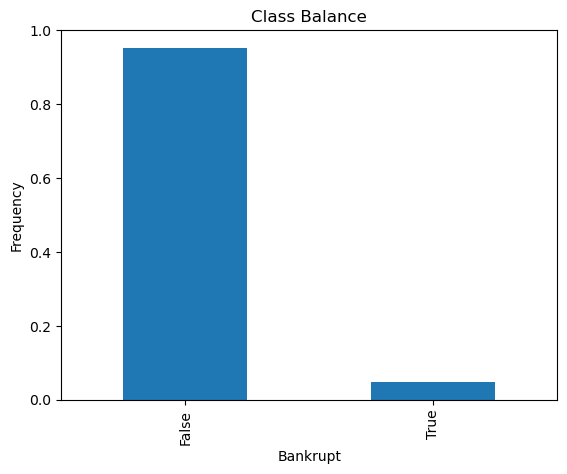

In [112]:
#Investigate the class balance
df["class"].value_counts(normalize = True).plot(
                                                kind = "bar",
                                                xlabel = "Bankrupt", 
                                                ylabel = "Frequency",
                                                title = "Class Balance");


Where b'1' represents the positive class(The company goes bankrupt) and b'0' represents the negative class (Company does not go bankrupt)

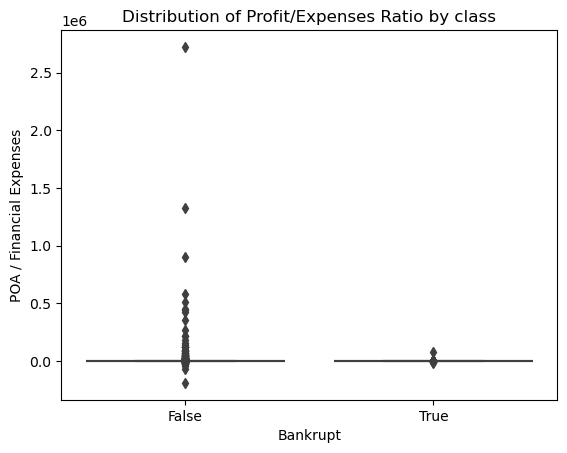

In [113]:
#Investigate bankruptcy based on company profitability
sns.boxplot(x = "class", y = "Attr27", data = df)
plt.xlabel("Bankrupt")
plt.ylabel("POA / Financial Expenses")
plt.title("Distribution of Profit/Expenses Ratio by class");
        

In [114]:
#Feature Summary Statistics
df["Attr27"].describe().apply("{0:,.0f}".format)

count        9,788
mean         1,186
std         34,691
min       -190,130
25%              0
50%              1
75%              5
max      2,723,000
Name: Attr27, dtype: object

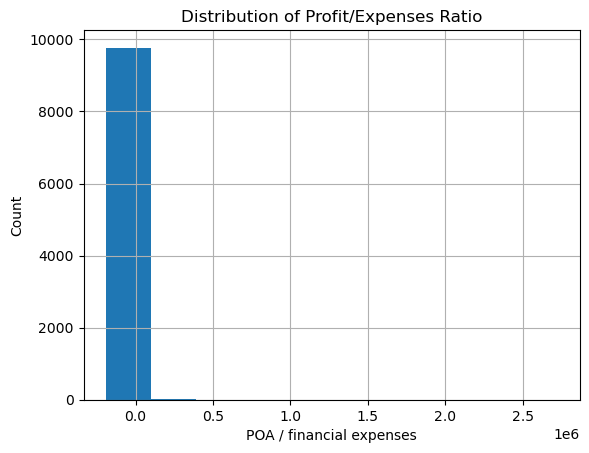

In [115]:
#Feature 27 histogram
df["Attr27"].hist()
plt.xlabel("POA / financial expenses")
plt.ylabel("Count"),
plt.title("Distribution of Profit/Expenses Ratio");

Summary statistics and histogram shows the data is highly skewed to the right

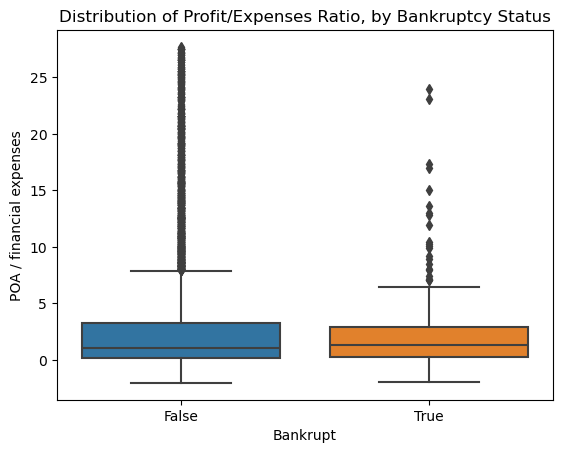

In [116]:
#Clipped feature histogram
q1, q9 = df["Attr27"].quantile([0.1, 0.9])
mask = df["Attr27"].between(q1,q9)
sns.boxplot(x = "class", y="Attr27", data = df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("POA / financial expenses")
plt.title("Distribution of Profit/Expenses Ratio, by Bankruptcy Status");

Checking for multicollinearity

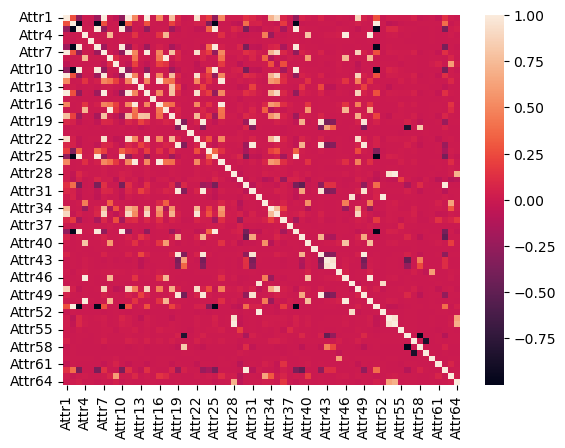

In [117]:
#Correlation matrix
corr = df.drop(columns = "class").corr()
sns.heatmap(corr);

Takeaways from EDA:
-First, our data is imbalanced. This is something we need to address in our data preparation.
-Many of our features have missing values that we'll need to impute. And since the features are highly skewed, the best imputation strategy is likely median, not mean.
-Finally, we have autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.

SPLIT

In [121]:
target = "class"
X = df.drop(columns = target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10503, 64)
y shape: (10503,)


In [122]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8402, 64)
y_train shape: (8402,)
X_test shape: (2101, 64)
y_test shape: (2101,)


## MODELLING

In [125]:
#Baseline Accuracy
y_train = y_train.ravel()  # Convert to shape (n_samples,)
y_train_series = pd.Series(y_train)

# Calculate baseline accuracy
acc_baseline = y_train_series.value_counts(normalize=True).max()
print("Baseline Accuracy:",round(acc_baseline, 4))


Baseline Accuracy: 0.9538


Note here that, because our classes are imbalanced, the baseline accuracy is very high. We should keep this in mind because, even if our trained model gets a high validation accuracy score, that doesn't mean it's actually good.

ITERATE: DecisionTreeClassifier

In [126]:
model_reg = make_pipeline(SimpleImputer(strategy = "median"), DecisionTreeClassifier(random_state =42))
# Fit on `X_train`, `y_train`
model_reg.fit(X_train, y_train)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(SimpleImputer(strategy = "median"), DecisionTreeClassifier(random_state =42))
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [128]:
for m in [model_reg,  model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9257
Training Accuracy: 1.0
Test Accuracy: 0.9453


CONFUSION MATRIX

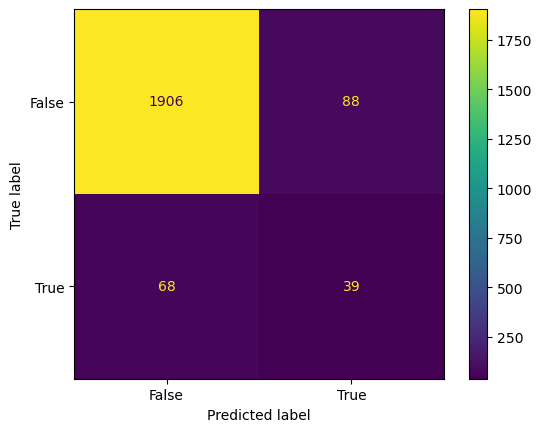

In [132]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test);

In [133]:
# Calculate Tree depth
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

36


### COMMUNICATION

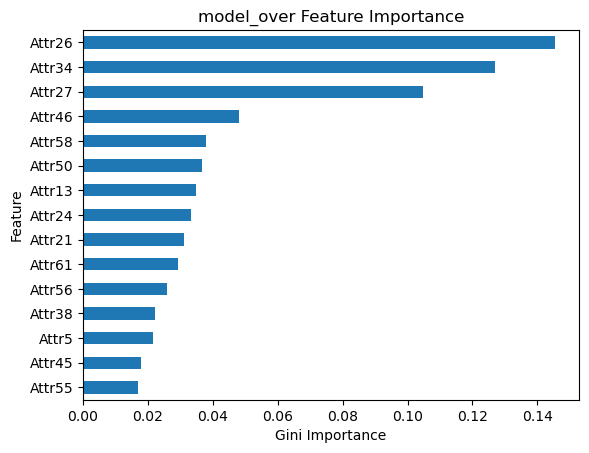

In [134]:
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index = X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

In [139]:
#Saving the model
with open("dt_classifier.pkl", "wb") as f:
    pickle.dump(model_over, f)